In [296]:
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [297]:
def load_excel_to_dataframe(file_path, sheet_name=0):
    """
    Reads an Excel file and returns its contents as a pandas DataFrame.

    Parameters:
    - file_path (str): The path to the Excel file.
    - sheet_name (str or int, optional): The sheet name or index to read. Defaults to the first sheet (0).

    Returns:
    - DataFrame: The contents of the specified Excel sheet as a DataFrame.
    """
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name) # Reading excel sheet directly using pandas in to dataframe
        df = process_dataframe(df)
        return df

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [298]:
def process_dataframe(df):
    # Filter entries between 9:30 AM and 3:55 PM
    df = df[(df['timestamp'].dt.hour > 9) & (df['timestamp'].dt.hour < 16)|
            ((df['timestamp'].dt.hour == 9) & (df['timestamp'].dt.minute >= 30)) |
            ((df['timestamp'].dt.hour == 15) & (df['timestamp'].dt.minute <= 55))]

    df = df.rename(columns={'o': 'Open', 'c': 'Close', 'h': 'High', 'l': 'Low', 'v': 'Volume'})

    print(df.head()) # DEBUG : added for debugging volume sum in the aggregation process

    # Extract hour from timestamp
    df['Hour'] = df['timestamp'].dt.hour

    # Calculate additional processed columns
    df['Price Difference Ratio'] = ((df['Close'] - df['Open']) / df['Open']) * 100
    df['Price Standard Deviation'] = df['Open'].rolling(window=14).std() # using a moving window of 14 time units (in case 14 15min blocks)
    df['Momentum Indicator'] = df['Close'] - df['Close'].shift(1)
    df['Range Ratio'] = (df['High'] - df['Low']) / df['Open']
    df['Price Range'] = df['High'] - df['Low']

    return df

In [299]:
def hourly_volatility_analysis(df):
    '''
    This function examines how trading patterns vary throughout the day by analyzing:

    Volume: Average trading volume per hour
        Higher volumes often indicate more active trading periods
        Used to identify peak trading hours and liquidity patterns


    Price Range: Average price volatility per hour
        Calculated as (High - Low) in each period
        Larger ranges indicate more price movement/volatility
        Helps identify hours with highest price volatility

    Momentum Indicator: Absolute average of momentum
        Takes the absolute value of momentum to measure strength regardless of direction
        Higher values indicate stronger price movements
        Using abs(mean) rather than mean(abs) shows overall directional strength

    '''
    hourly_volatility_df = df.groupby('Hour').agg({
        'Volume' : 'mean',
        'Price Range' : 'mean',
        'Momentum Indicator' : lambda x: abs(x.mean()),
        'Hour' : 'count'
    }).rename(columns = {
        'Volume': 'avgVolume',
        'Price Range': 'avgPriceRange',
        'Momentum Indicator': 'avgMomentum',
        'Hour': 'count'
    }).reset_index()

    return hourly_volatility_df

In [300]:
def momentum_reversal_analysis(df):
    """
    Uses sign change detection: np.sign(current) != np.sign(previous)
        Positive to negative = Uptrend to downtrend
        Negative to positive = Downtrend to uptrend
        Zero crossings can indicate trend exhaustion

    Includes associated metrics:
        Volume at reversal point (potential confirmation)
        Price range (volatility during reversal)
        Previous and current momentum values (reversal strength)
    """
    df['prevMomentum'] = df['Momentum Indicator'].shift(1) #NOTE; the first element will be NaN whe using shift(1

    momentum_reversals = df[
        (np.sign(df['Momentum Indicator']) != np.sign(df['prevMomentum'])) &
        (~df['prevMomentum'].isna())
    ].assign(
        timestamp=df['timestamp'],
        currentMomentum=df['Momentum Indicator'],
        volume=df['Volume'],
        priceRange=df['Price Range']
    )[['timestamp', 'currentMomentum', 'prevMomentum', 'volume', 'priceRange']]

    return momentum_reversals

In [301]:
# High Volume Price Impact Analysis
def high_volume_price_impact_analysis(df):
    '''
    Volume Threshold: mean * 2
        Uses 2x average volume as significance threshold
        Identifies periods of unusually high activity
        Statistical outlier detection for volume spikes

    Tracks associated metrics:
        Price change ratio (impact on price)
        Price range (volatility during high volume)
        Timestamp (temporal clustering of events)
    '''

    volume_threshold = df['Volume'].mean() * 2
    high_volume_events = df[df['Volume'] > volume_threshold].assign(
        timestamp=df['timestamp'],
        volume=df['Volume'],
        priceChange=df['Price Difference Ratio'],
        priceRange=df['Price Range']
    )[['timestamp', 'volume', 'priceChange', 'priceRange']]

    return high_volume_events

In [302]:
def create_stock_pattern_visualizations(df, hourly_volatility_df, momentum_reversals, high_volume_events, filename_no_ext):
    plt.figure(figsize=(20,20))
    plt.suptitle('Comprehensive Stock Pattern Analysis', fontsize=16)

    # 1. Hourly Volume Analysis
    plt.subplot(3, 2, 1)
    plt.bar(hourly_volatility_df['Hour'], hourly_volatility_df['avgVolume'])
    plt.title('Average Volume by Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Volume')
    plt.xticks(rotation=45)

    # 2. Hourly Price Range Analysis
    plt.subplot(3, 2, 2)
    plt.bar(hourly_volatility_df['Hour'], hourly_volatility_df['avgPriceRange'], color='orange')
    plt.title('Average Price Range by Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Price Range')
    plt.xticks(rotation=45)

    # 3. Momentum Reversals Scatter
    plt.subplot(3, 2, 3)
    plt.scatter(momentum_reversals['currentMomentum'], momentum_reversals['volume'],
                alpha=0.6, c=momentum_reversals['priceRange'], cmap='viridis')
    plt.colorbar(label='Price Range')
    plt.title('Momentum Reversals: Momentum vs Volume')
    plt.xlabel('Current Momentum')
    plt.ylabel('Volume')

    # 4. High Volume Events
    plt.subplot(3, 2, 4)
    plt.scatter(high_volume_events['volume'], high_volume_events['priceChange'],
                alpha=0.6, c=high_volume_events['priceRange'], cmap='plasma')
    plt.colorbar(label='Price Range')
    plt.title('High Volume Events: Volume vs Price Change')
    plt.xlabel('Volume')
    plt.ylabel('Price Change (%)')

    # 5. Correlation Heatmap
    plt.subplot(3, 2, 5)
    correlation_columns = ['Volume', 'Open', 'Close', 'High', 'Low', 'Price Range']
    correlation_matrix = df[correlation_columns].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap')

    # 6. Momentum Reversal Histogram
    plt.subplot(3, 2, 6)
    plt.hist(momentum_reversals['currentMomentum'], bins=30, edgecolor='black')
    plt.title('Distribution of Momentum at Reversal Points')
    plt.xlabel('Momentum')
    plt.ylabel('Frequency')

    plt.tight_layout()
    # save the graph to a file
    plt.savefig(f'PatternAnalysis_{filename_no_ext}.png')
    plt.show()


In [303]:
def main ():

    ## CHOOSE THE CORRECT FILE PATH (comment off the other ones)
    #data from polygon.io
    file_path = 'data/generated_data/SPY_Historical_Data_polygon_1minute_dur7d_2025-01-30_to_2025-02-06.xlsx'  # Replace with your actual file path

    # # data from yahoo
    # file_path = 'data/generated_data/SPY_yfinance_7d_5m_2025-01-24_to_2025-02-03_processed.xlsx'  # Replace with your actual file path

    sheet_name = 'Sheet1'         # Replace with your actual sheet name

    # load excel sheet with correct time interval
    df_raw = load_excel_to_dataframe(file_path, sheet_name)
    # process the raw dataframe by adding other relevant columns
    df = process_dataframe(df_raw) # or index

    #### KNOWN Pattern Analysis
    df_hourly_volatility = hourly_volatility_analysis(df)
    df_momentum_reversals = momentum_reversal_analysis(df)
    df_high_volume_price_impact = high_volume_price_impact_analysis(df)

    # get the filename without the extension
    filename = os.path.basename(file_path)
    filename_no_ext = os.path.splitext(filename)[0]

    # Create visualizations
    create_stock_pattern_visualizations(df, df_hourly_volatility, df_momentum_reversals, df_high_volume_price_impact, filename_no_ext)


             timestamp    Open    High     Low   Close  Volume
13 2025-01-30 09:30:00  604.58  604.58  604.58  604.58     697
14 2025-01-30 09:31:00  604.54  604.56  604.54  604.56     403
15 2025-01-30 09:37:00  604.21  604.23  604.18  604.23    1962
16 2025-01-30 09:41:00  604.26  604.26  604.26  604.26     562
17 2025-01-30 09:46:00  604.28  604.28  604.28  604.28     208
             timestamp    Open    High     Low   Close  Volume  Hour  \
13 2025-01-30 09:30:00  604.58  604.58  604.58  604.58     697     9   
14 2025-01-30 09:31:00  604.54  604.56  604.54  604.56     403     9   
15 2025-01-30 09:37:00  604.21  604.23  604.18  604.23    1962     9   
16 2025-01-30 09:41:00  604.26  604.26  604.26  604.26     562     9   
17 2025-01-30 09:46:00  604.28  604.28  604.28  604.28     208     9   

    Price Difference Ratio  Price Standard Deviation  Momentum Indicator  \
13                0.000000                       NaN                 NaN   
14                0.003308           

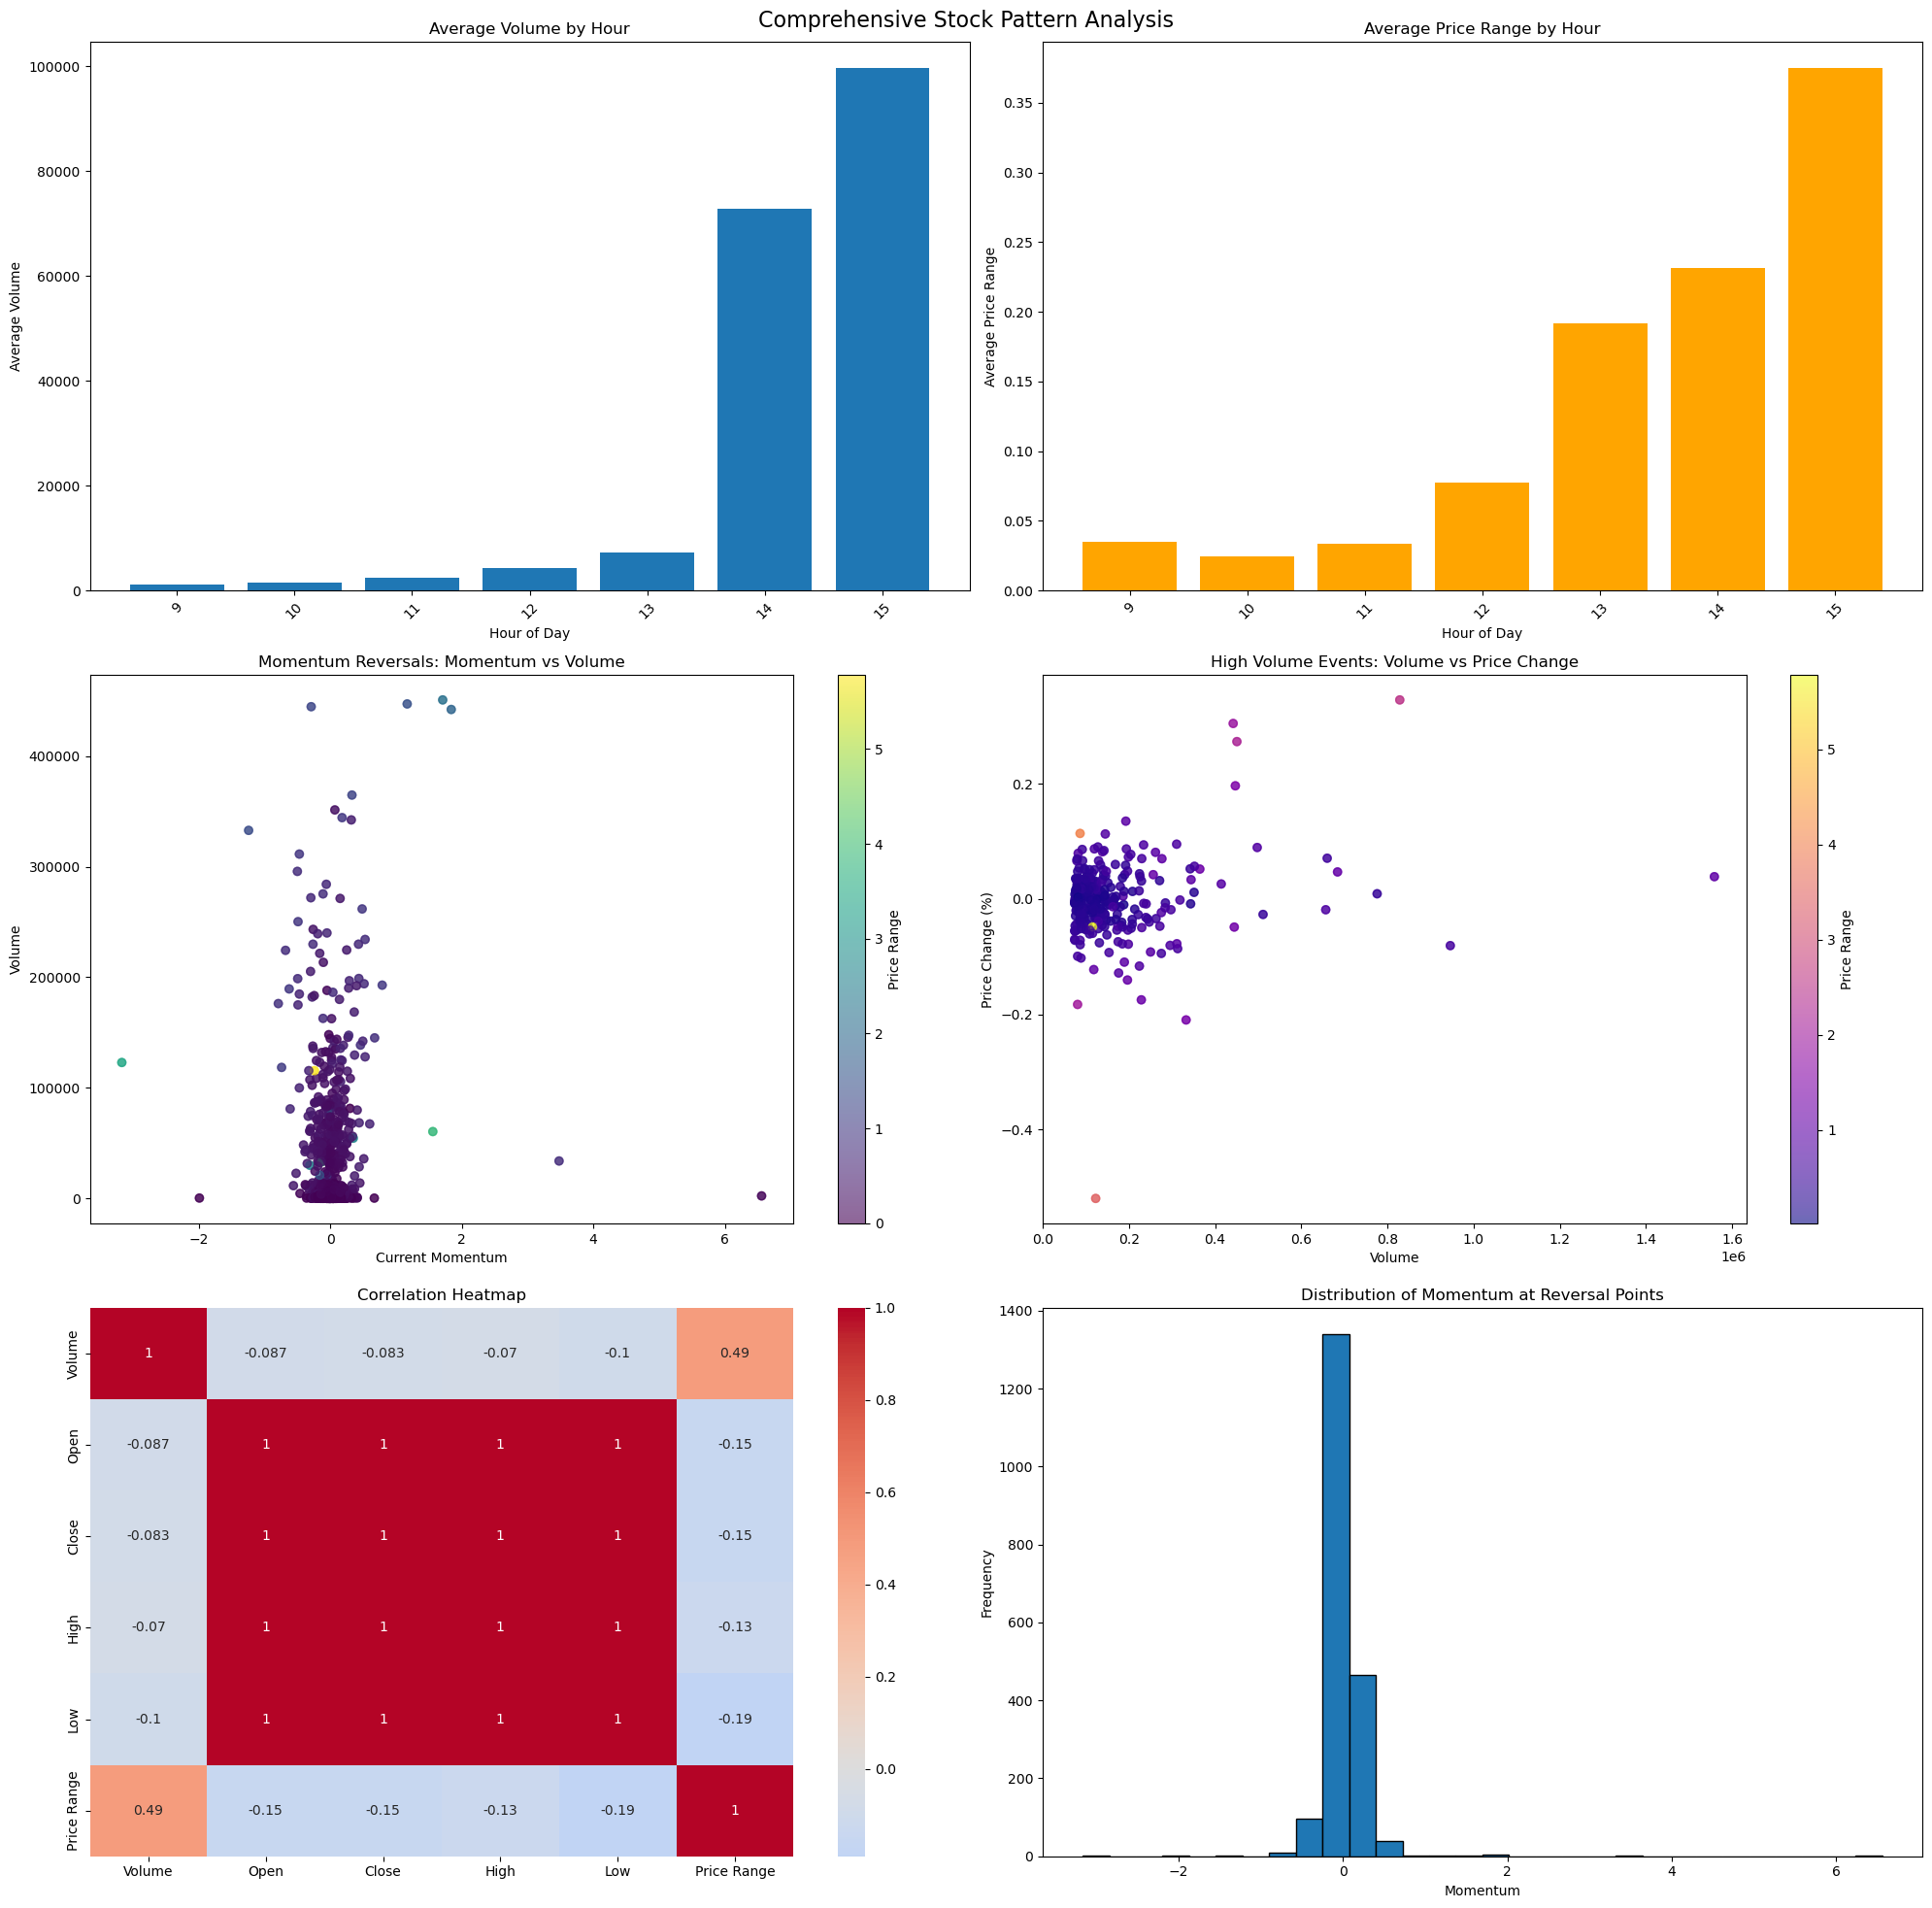

In [304]:
if __name__ == '__main__':
    main()